In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [80]:
## Below is some helper code to read data for you.
## Load NIH data
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Finding Labels'] =  all_xray_df['Finding Labels'].str.split('|')
all_labels = all_xray_df['Finding Labels'].explode().unique()
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(set)
for label in all_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda x: 1 if label in x else 0)
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
sample_df['Finding Labels'] = sample_df['Finding Labels'].str.split('|').map(set)
for label in all_labels:
    sample_df[label] = sample_df['Finding Labels'].map(lambda x: 1 if label in x else 0)
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
3339,00016497_001.png,{No Finding},1,16497,064Y,F,AP,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,0,0
2307,00011771_000.png,{No Finding},0,11771,014Y,M,PA,2992,2809,0.143000,...,0,0,0,0,0,0,0,0,0,0
3681,00018055_032.png,{No Finding},32,18055,064Y,M,PA,2021,2021,0.194311,...,0,0,0,0,0,0,0,0,0,0


## EDA

### The patient demographic data such as gender, age, patient position,etc. (as it is available)

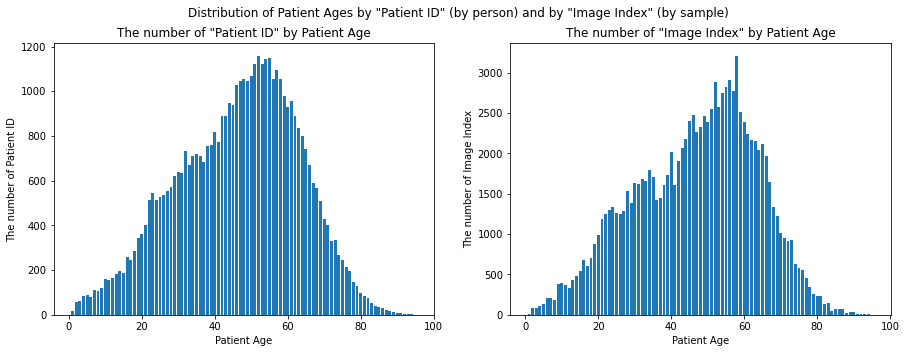

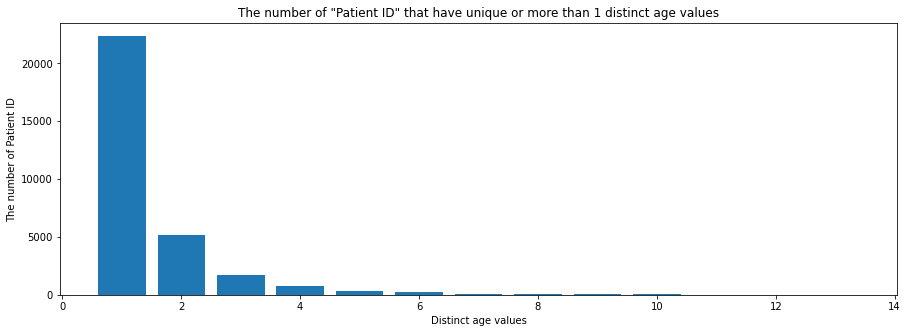

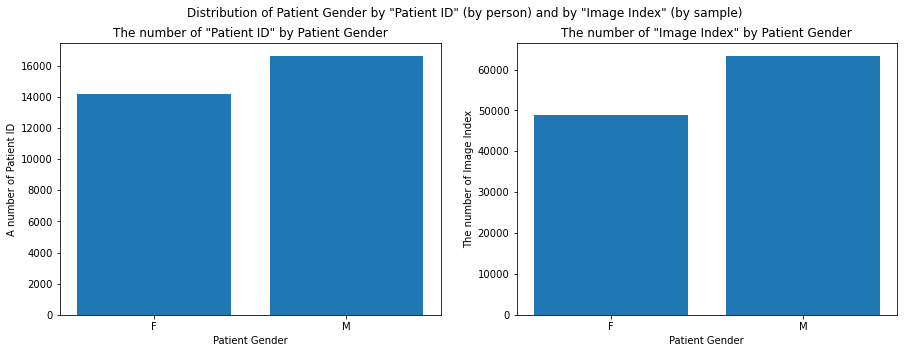

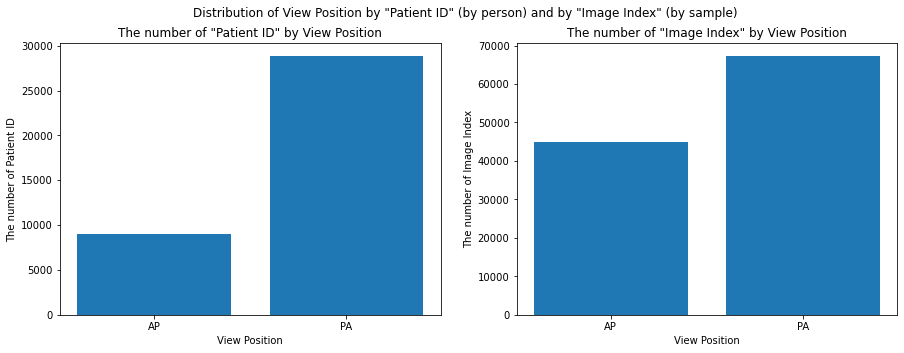

In [3]:
# prepare demographics (filter out unreasonable data e.g. age <=0 or >120)
def plot_bar(ax, x, height, data, title, xlab, ylab):
    ax.bar(x = x, height = height, data = data)
    ax.set_title(title)
    ax.set(xlabel = xlab, ylabel= ylab)
demographic = all_xray_df[['Image Index', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position']]
demographic = demographic[(demographic['Patient Age'] > 0) &  (demographic['Patient Age'] <= 120)]

    
# plot Distribution of Patient Ages by "Patient ID" (by person) and by "Image Index" (by sample)
patient_age = demographic.groupby('Patient Age')[['Image Index', 'Patient ID']].nunique().reset_index()
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))    
plot_bar(ax1, x = 'Patient Age', height = 'Patient ID', data = patient_age, 
         title = 'The number of "Patient ID" by Patient Age',  
         xlab = 'Patient Age', ylab = 'The number of Patient ID')
plot_bar(ax2, x = 'Patient Age', height =  'Image Index', data = patient_age, 
         title = 'The number of "Image Index" by Patient Age', 
         xlab = 'Patient Age', ylab = 'The number of Image Index')
fig.suptitle('Distribution of Patient Ages by "Patient ID" (by person) and by "Image Index" (by sample)')
plt.show()
print('')

# plot 'The number of "Patient ID" that have unique or more than 1 distinct age values
patient_multiage = demographic.groupby('Patient ID')[['Patient Age']].nunique().reset_index()
patient_multiage = patient_multiage.groupby('Patient Age')[['Patient ID']].count().reset_index()
fig, ax = plt.subplots(figsize=(15,5))
plot_bar(ax, x = 'Patient Age', height =  'Patient ID', data = patient_multiage, 
         title = 'The number of "Patient ID" that have unique or more than 1 distinct age values', 
         xlab = 'Distinct age values', ylab = 'The number of Patient ID')
plt.show()
print('')

# gender
gender = demographic.groupby('Patient Gender')[['Image Index', 'Patient ID']].nunique().reset_index()
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))    
plot_bar(ax1, x = 'Patient Gender', height = 'Patient ID', data = gender, 
         title = 'The number of "Patient ID" by Patient Gender',  
         xlab = 'Patient Gender', ylab = 'A number of Patient ID')
plot_bar(ax2, x = 'Patient Gender', height =  'Image Index', data = gender, 
         title = 'The number of "Image Index" by Patient Gender', 
         xlab = 'Patient Gender', ylab = 'The number of Image Index')
fig.suptitle('Distribution of Patient Gender by "Patient ID" (by person) and by "Image Index" (by sample)')
plt.show()
print('')

# patient position
position = demographic.groupby('View Position')[['Image Index', 'Patient ID']].nunique().reset_index()
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))    
plot_bar(ax1, x = 'View Position', height = 'Patient ID', data = position, 
         title = 'The number of "Patient ID" by View Position',  
         xlab = 'View Position', ylab = 'The number of Patient ID')
plot_bar(ax2, x = 'View Position', height =  'Image Index', data = position, 
         title = 'The number of "Image Index" by View Position', 
         xlab = 'View Position', ylab = 'The number of Image Index')
fig.suptitle('Distribution of View Position by "Patient ID" (by person) and by "Image Index" (by sample)')
plt.show()
print('')

### The number of cases including: <br />
- number of pneumonia cases, <br />
- number of non-pneumonia cases

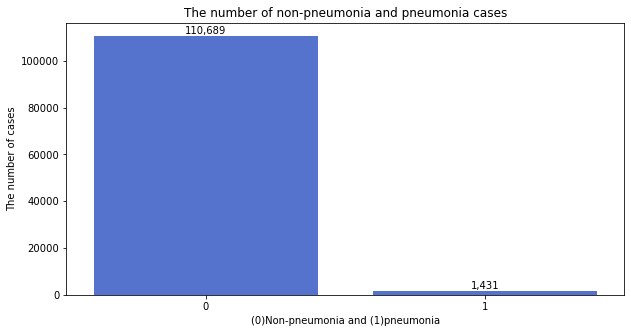

In [4]:
import warnings
warnings.filterwarnings('ignore')

# preparing cases table
cases = all_xray_df[['Image Index', 'Patient ID', 'Finding Labels'] + all_labels.tolist()]
cases['Finding Labels'] = cases['Finding Labels'].map(list)
    
# plot the number of non-pneumonia and pneumonia cases  
pneumonia = cases[['Image Index', 'Pneumonia']]
pneumonia = pneumonia.groupby('Pneumonia')['Image Index'].nunique().reset_index()
fig, ax = plt.subplots(figsize=(10,5))    
sns.barplot(ax = ax, x= 'Pneumonia', y = 'Image Index',data= pneumonia, color = 'royalblue')
ax.set_title('The number of non-pneumonia and pneumonia cases')
ax.set(xlabel = '(0)Non-pneumonia and (1)pneumonia', ylabel= 'The number of cases')
for index, row in pneumonia.iterrows():
    text = f"""{row['Image Index']:,}"""
    ax.text(index, row['Image Index'] + 1000, text, color='black', ha="center")
plt.show()

### Distribution of basic demographics consists only of patients with pneumonia

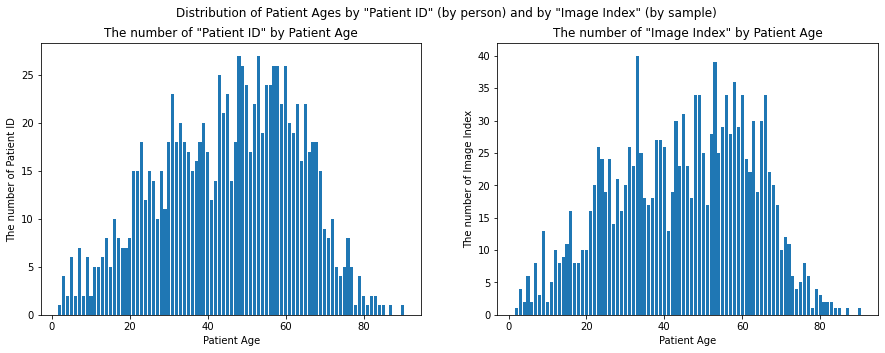

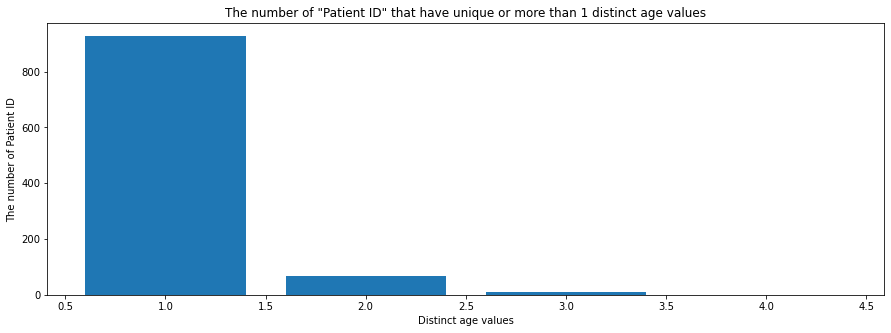

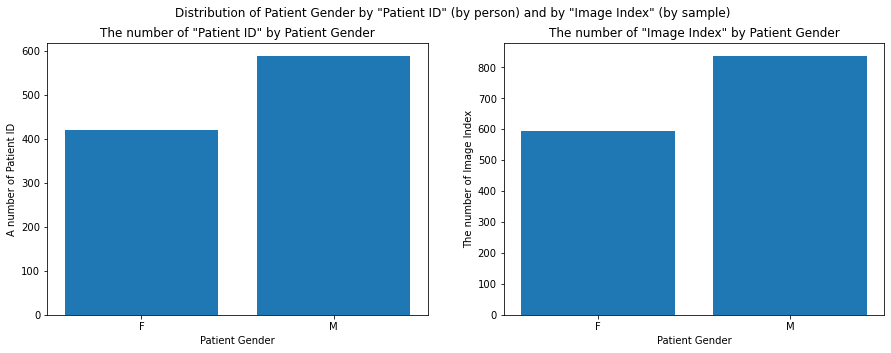

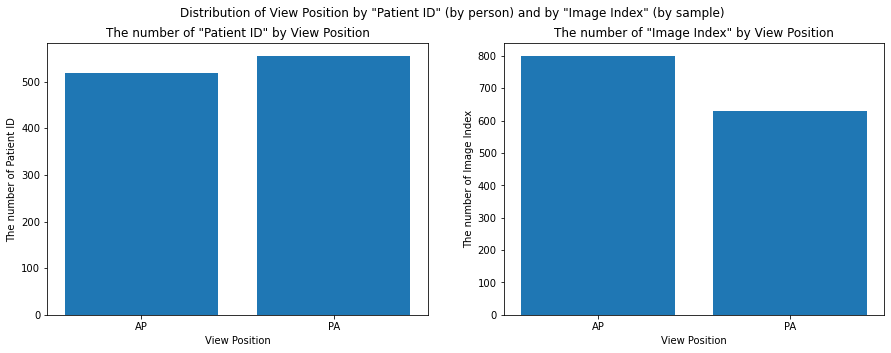

In [4]:
# prepare demographics (filter out unreasonable data e.g. age <=0 or >120)
def plot_bar(ax, x, height, data, title, xlab, ylab):
    ax.bar(x = x, height = height, data = data)
    ax.set_title(title)
    ax.set(xlabel = xlab, ylabel= ylab)
demographic = all_xray_df[['Image Index', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'Pneumonia']]
demographic = demographic[(demographic['Patient Age'] > 0) &  (demographic['Patient Age'] <= 120)]
demographic = demographic[demographic.Pneumonia == 1]
    
# plot Distribution of Patient Ages by "Patient ID" (by person) and by "Image Index" (by sample)
patient_age = demographic.groupby('Patient Age')[['Image Index', 'Patient ID']].nunique().reset_index()
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))    
plot_bar(ax1, x = 'Patient Age', height = 'Patient ID', data = patient_age, 
         title = 'The number of "Patient ID" by Patient Age',  
         xlab = 'Patient Age', ylab = 'The number of Patient ID')
plot_bar(ax2, x = 'Patient Age', height =  'Image Index', data = patient_age, 
         title = 'The number of "Image Index" by Patient Age', 
         xlab = 'Patient Age', ylab = 'The number of Image Index')
fig.suptitle('Distribution of Patient Ages by "Patient ID" (by person) and by "Image Index" (by sample)')
plt.show()
print('')

# plot 'The number of "Patient ID" that have unique or more than 1 distinct age values
patient_multiage = demographic.groupby('Patient ID')[['Patient Age']].nunique().reset_index()
patient_multiage = patient_multiage.groupby('Patient Age')[['Patient ID']].count().reset_index()
fig, ax = plt.subplots(figsize=(15,5))
plot_bar(ax, x = 'Patient Age', height =  'Patient ID', data = patient_multiage, 
         title = 'The number of "Patient ID" that have unique or more than 1 distinct age values', 
         xlab = 'Distinct age values', ylab = 'The number of Patient ID')
plt.show()
print('')

# gender
gender = demographic.groupby('Patient Gender')[['Image Index', 'Patient ID']].nunique().reset_index()
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))    
plot_bar(ax1, x = 'Patient Gender', height = 'Patient ID', data = gender, 
         title = 'The number of "Patient ID" by Patient Gender',  
         xlab = 'Patient Gender', ylab = 'A number of Patient ID')
plot_bar(ax2, x = 'Patient Gender', height =  'Image Index', data = gender, 
         title = 'The number of "Image Index" by Patient Gender', 
         xlab = 'Patient Gender', ylab = 'The number of Image Index')
fig.suptitle('Distribution of Patient Gender by "Patient ID" (by person) and by "Image Index" (by sample)')
plt.show()
print('')

# patient position
position = demographic.groupby('View Position')[['Image Index', 'Patient ID']].nunique().reset_index()
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))    
plot_bar(ax1, x = 'View Position', height = 'Patient ID', data = position, 
         title = 'The number of "Patient ID" by View Position',  
         xlab = 'View Position', ylab = 'The number of Patient ID')
plot_bar(ax2, x = 'View Position', height =  'Image Index', data = position, 
         title = 'The number of "Image Index" by View Position', 
         xlab = 'View Position', ylab = 'The number of Image Index')
fig.suptitle('Distribution of View Position by "Patient ID" (by person) and by "Image Index" (by sample)')
plt.show()
print('')

##### Conclusion: 

There are far more negative labels than positive labels. In the training process, the distribution of the label in validation dataset should reflect the real environment that the model is intended to use. And the training set shold be balanced. Thus, we may use sampling technique to solve this problem.

For example, The validation set can be an imbalanced dataset containing 20% pneumonia cases and a total of 1430 images sampled from the original dataset.

And the training dataset can be the balanced dataset sampled from the original dataset but should not include the same samples in the validation set. 

### The distribution of other diseases that are comorbid with pneumonia

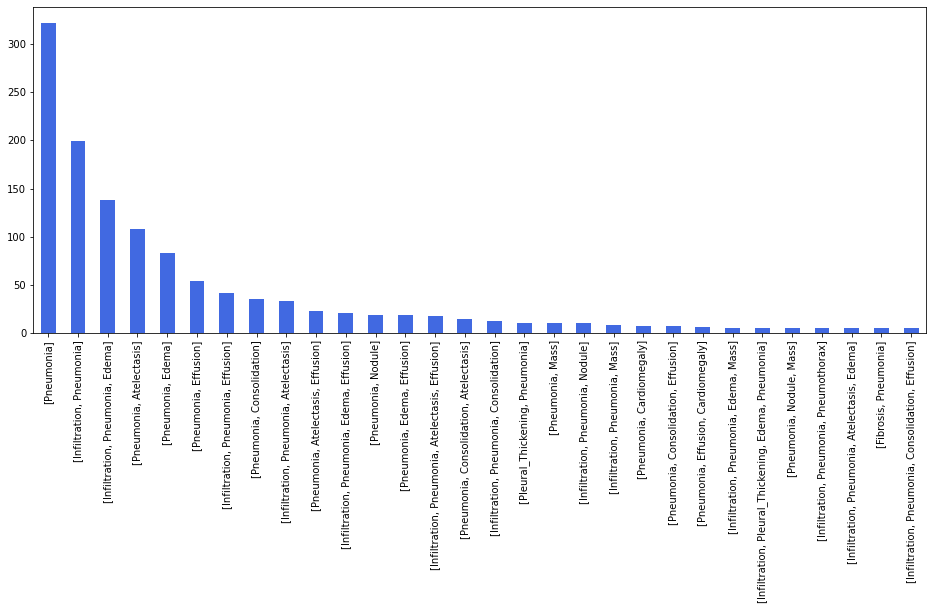

In [5]:
plt.figure(figsize=(16,6))
cases[cases.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar', color = 'royalblue')
plt.show()

In [6]:
from scipy import sparse

print('We want to observe more info about other diseases that are comorbid with pneumonia as follows')
print('- Frequency of each label (The number of Image Index for each label)')
print('- Coocurance of pairs of Pneumonia with other labels')
print('- Similarity of pairs of Pneumonia with other labels based on Jaccard values')

# label frequency
label_freq = cases[['Image Index', 'Finding Labels']].explode('Finding Labels')
label_freq = label_freq[label_freq['Finding Labels'] != 'No Finding']
label_freq = label_freq.groupby('Finding Labels')['Image Index'].nunique().reset_index()
label_freq = label_freq.rename(columns = {'Image Index': 'label_freq'})
display(label_freq.sort_values('label_freq', ascending = False))

# comorbid_pneumonia
comorbid_pneumonia = cases.loc[cases.Pneumonia==1, ['Image Index', 'Finding Labels']].explode('Finding Labels')
comorbid_pneumonia = pd.merge(comorbid_pneumonia, comorbid_pneumonia, on = 'Image Index')
comorbid_pneumonia = comorbid_pneumonia.groupby(['Finding Labels_x', 'Finding Labels_y'])['Image Index'].nunique().reset_index()
jaccard_pneumonia = pd.merge(comorbid_pneumonia, label_freq, left_on = 'Finding Labels_x', right_on = 'Finding Labels').drop(columns = 'Finding Labels')
jaccard_pneumonia = pd.merge(jaccard_pneumonia, label_freq, left_on = 'Finding Labels_y', right_on = 'Finding Labels').drop(columns = 'Finding Labels')
jaccard_pneumonia['jaccard'] = jaccard_pneumonia['Image Index']/(jaccard_pneumonia['label_freq_x']+ jaccard_pneumonia['label_freq_y'] - jaccard_pneumonia['Image Index']) 
jaccard_pneumonia = jaccard_pneumonia.rename(columns = {'Image Index': 'cooccurrence',
                                                        'Finding Labels_x': 'interested_label',
                                                         'Finding Labels_y': 'cooccur_label'})
jaccard_pneumonia = jaccard_pneumonia[jaccard_pneumonia['interested_label'] == 'Pneumonia'].drop(columns = ['label_freq_x', 'label_freq_y'])
jaccard_pneumonia.sort_values('cooccurrence', ascending = False)

We want to observe more info about other diseases that are comorbid with pneumonia as follows
- Frequency of each label (The number of Image Index for each label)
- Coocurance of pairs of Pneumonia with other labels
- Similarity of pairs of Pneumonia with other labels based on Jaccard values


,Finding Labels,label_freq
8,Infiltration,19894
4,Effusion,13317
0,Atelectasis,11559
10,Nodule,6331
9,Mass,5782
13,Pneumothorax,5302
2,Consolidation,4667
11,Pleural_Thickening,3385
1,Cardiomegaly,2776
5,Emphysema,2516


,interested_label,cooccur_label,cooccurrence,jaccard
135,Pneumonia,Pneumonia,1431,1.000000
84,Pneumonia,Infiltration,605,0.029199
46,Pneumonia,Edema,340,0.100177
60,Pneumonia,Effusion,269,0.018579
10,Pneumonia,Atelectasis,262,0.020585
34,Pneumonia,Consolidation,123,0.020586
96,Pneumonia,Mass,71,0.009941
108,Pneumonia,Nodule,70,0.009100
121,Pneumonia,Pleural_Thickening,48,0.010067
21,Pneumonia,Cardiomegaly,41,0.009842


##### Conclusion:
    
Based on jaccard similarity, Edema and Pneumonia specifically occurs together more than other pairs of disease (co-occurance = 340 cases, occurs separately = 3054 cases, jaccard = 340/(340 + 3054) = 0.100177). 

If we want to include some comorbid disease as positive label to reduce false positive, Edema may be one of a good choice. Howevers, if Edema are easily distinguished from other cases, the result can be worst either. 

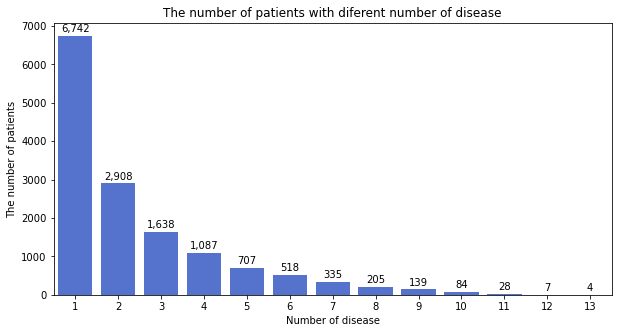

In [7]:
disease_per_patient = cases[['Patient ID', 'Finding Labels']].explode('Finding Labels')
disease_per_patient = disease_per_patient[disease_per_patient['Finding Labels'] != 'No Finding']
disease_per_patient = disease_per_patient.groupby('Patient ID')['Finding Labels'].nunique().reset_index()
disease_per_patient = disease_per_patient.groupby('Finding Labels')['Patient ID'].count().reset_index()

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(ax = ax, x= 'Finding Labels', y = 'Patient ID',data= disease_per_patient, color = 'royalblue')
ax.set_title('The number of patients with diferent number of disease')
ax.set(xlabel = 'Number of disease', ylabel= 'The number of patients')
for index, row in disease_per_patient.iterrows():
    text = f"""{row['Patient ID']:,}"""
    ax.text(index, row['Patient ID'] + 100, text, color='black', ha="center")
plt.show()

### Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

We will use only 5606 images for the pixel-level assassements. These images have the similar percentage of Pneumonia cases to the full image set. 

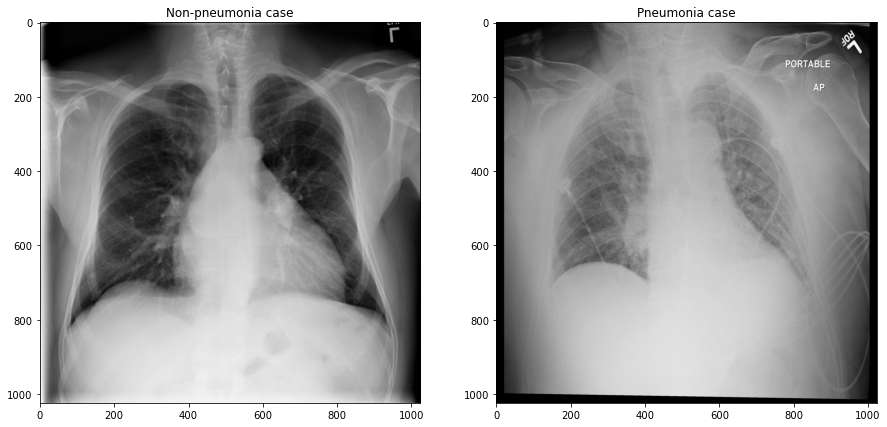

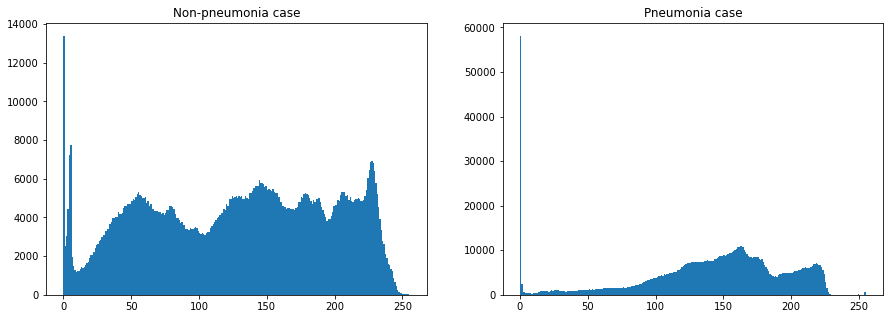

In [16]:
from PIL import Image

# prepare pneumonia and non_pneumonia datasets
pneumonia = sample_df[sample_df.Pneumonia == 1]
non_pneumonia = sample_df[sample_df.Pneumonia == 0]

# show image of  Non-Pneumonia' and 'Pneumonia
pneumonia_fn = pneumonia.path.iloc[0] 
non_pneumonia_fn = non_pneumonia.path.iloc[0]
pneumonia_im = Image.open(pneumonia_fn)
non_pneumonia_im = Image.open(non_pneumonia_fn) 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(non_pneumonia_im, cmap='gray')
ax1.set_title('Non-pneumonia case')
ax2.imshow(pneumonia_im, cmap='gray')
ax2.set_title('Pneumonia case')
plt.show()

# Show intensity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.hist(np.asarray(non_pneumonia_im).ravel(), bins = 255)
ax1.set_title('Non-pneumonia case')
ax2.hist(np.asarray(pneumonia_im).ravel(), bins = 255)
ax2.set_title('Pneumonia case')
plt.show()

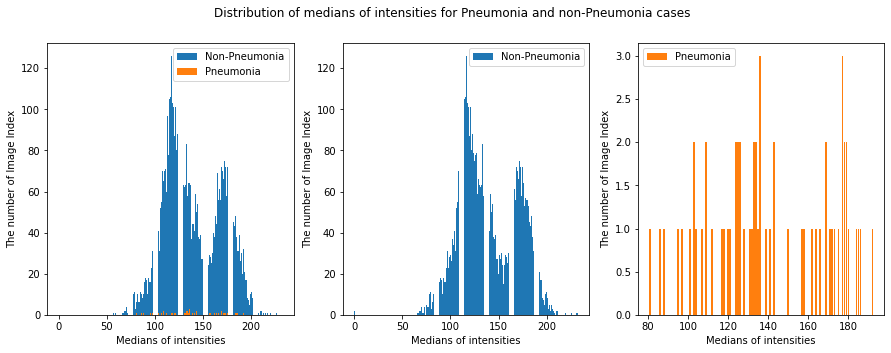

In [17]:
# get median_intensity of all sample images
def get_median_intensity(fn):
    with Image.open(fn) as im:
        im = np.asarray(im)
        median = np.median(im)
    return median
pneumonia['median_intensity'] = pneumonia.path.map(get_median_intensity)
non_pneumonia['median_intensity'] = non_pneumonia.path.map(get_median_intensity)

# Plot
fig, axs = fig, axs  = plt.subplots(1, 3, figsize=(15,5))
axs[0].bar(x = 'median_intensity', height = 'Image Index', data = non_pneumonia.groupby('median_intensity')['Image Index'].count().reset_index()) 
axs[0].bar(x = 'median_intensity', height = 'Image Index', data = pneumonia.groupby('median_intensity')['Image Index'].count().reset_index())
axs[0].set(xlabel = 'Medians of intensities', ylabel = 'The number of Image Index')
axs[0].legend(['Non-Pneumonia', 'Pneumonia'])

axs[1].bar(x = 'median_intensity', height = 'Image Index', data = non_pneumonia.groupby('median_intensity')['Image Index'].count().reset_index())
axs[1].set(xlabel = 'Medians of intensities', ylabel = 'The number of Image Index')
axs[1].legend(['Non-Pneumonia'])

axs[2].bar(color='#ff7f0e', x = 'median_intensity', height = 'Image Index', data = pneumonia.groupby('median_intensity')['Image Index'].count().reset_index())
axs[2].set(xlabel = 'Medians of intensities', ylabel = 'The number of Image Index')
axs[2].legend(['Pneumonia'])

fig.suptitle('Distribution of medians of intensities for Pneumonia and non-Pneumonia cases')
plt.show()

We can see that the median of intensity alone is not a good features to distinguish Pneumonia and non-Pneumonia cases.

#### Image and distribution in no-diseases, pneumonia, and some most common comorbid diseases

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


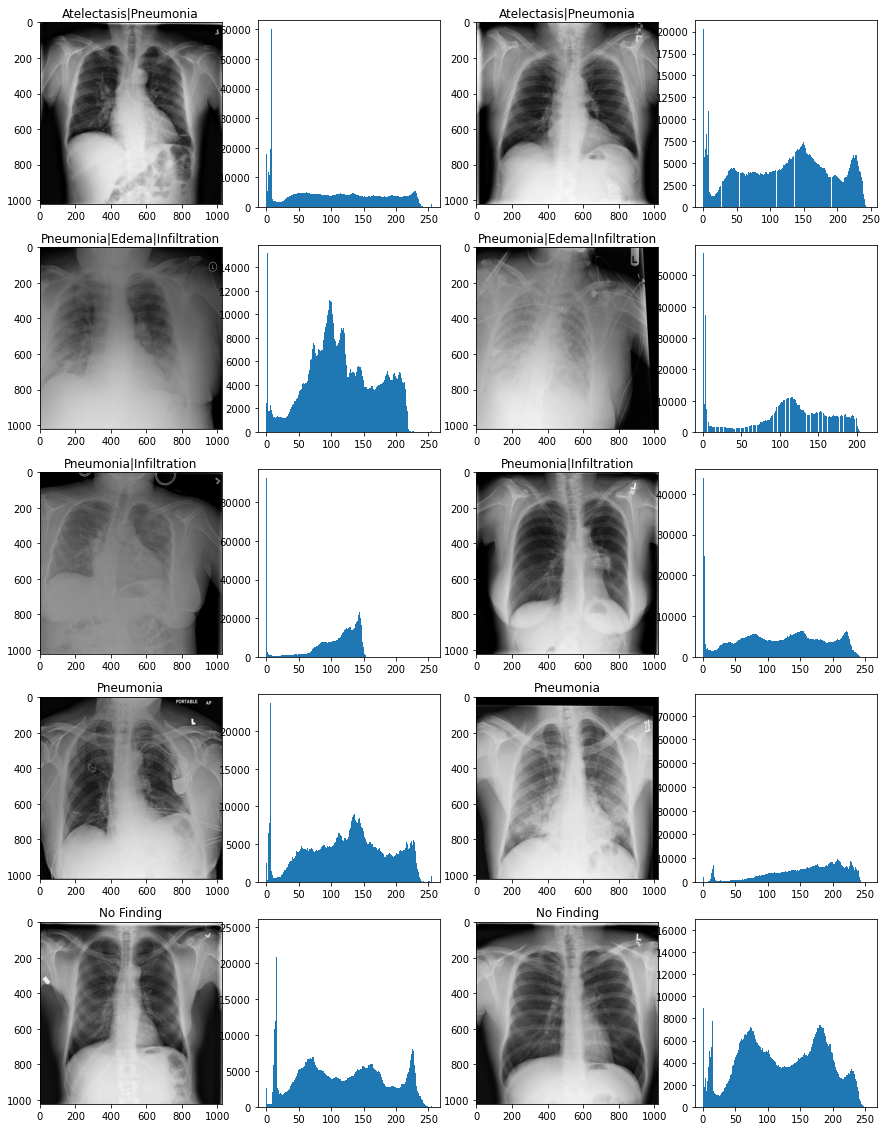

In [107]:
from PIL import Image

# get top comorbid_diseases
sample_df = all_xray_df[(all_xray_df.Pneumonia == 1) | (all_xray_df['No Finding'] == 1)]
sample_df['Finding Labels'] = sample_df['Finding Labels'].map(list).str.join('|')
top_comorbid_diseases = sample_df.groupby('Finding Labels')['Image Index'].count().sort_values()[-5:].index.tolist()
all_labels =  top_comorbid_diseases
# select  comorbid_diseases


fig, axs = plt.subplots(len(all_labels), 4, figsize=(15,20))
i = 0
for i, cd in  enumerate(all_labels):
    comorbid_diseases = sample_df[sample_df['Finding Labels'] == cd].sample(2).reset_index()
    
    for  j, row in comorbid_diseases.iterrows():
        # plot xray
        im_fn = row['path'] 
        im = Image.open(im_fn)
        axs[i, 2*j].imshow(im, cmap='gray')  
        axs[i, 2*j].set_title(cd)
            
        # plot density   
        axs[i,  2*j + 1].hist(np.asarray(im).ravel(), bins = 255)
        
plt.show()
 
    
    


##### Conclusion:

The difference between distribution of diseases are not easily seen. Howevers, some images with diseases seem to have more bright pixel ratio compared those with no diseases.